In [1]:
import torch
from trainer import Trainer
from models import NN_CartPole, NN_Humanoid, NN_Hopper

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("You are using device: %s" % device)

You are using device: mps


In [3]:
# str_env = "Humanoid-v5"
str_env = "Hopper-v5"
# str_env = "CartPole-v1"

In [4]:
updates = {"CartPole-v1": 100, "Humanoid-v5": 1000, "Hopper-v5": 500}
epochs = {"CartPole-v1": 8, "Humanoid-v5": 8, "Hopper-v5": 12} # Hopper-v5: [8, 12, 16]
N = {"CartPole-v1": 4, "Humanoid-v5": 4, "Hopper-v5": 4} # Hopper-v5: [2, 4, 6]
T = {"CartPole-v1": 256, "Humanoid-v5": 256, "Hopper-v5": 512} # Hopper-v5: [, 256, ]
batches = {"CartPole-v1": 4, "Humanoid-v5": 4, "Hopper-v5": 4}
value_loss_coef = {"CartPole-v1": 0.5, "Humanoid-v5": 0.5, "Hopper-v5": 1.0}
entropy_bonus_coef = {"CartPole-v1": 1e-3, "Humanoid-v5": 1e-3, "Hopper-v5": 1e-5} # Hopper-v5: [, 1e-5, 5e-4]
clip_range = {"CartPole-v1": 0.1, "Humanoid-v5": 0.1, "Hopper-v5": 0.1}
learning_rate = {"CartPole-v1": 1e-3, "Humanoid-v5": 1e-3, "Hopper-v5": 1e-4} # Hopper-v5: [1e-5, 1e-4, 1e-3]
learning_rate_decay = {"CartPole-v1": 0.999, "Humanoid-v5": 0.999, "Hopper-v5": 0.999}
reward_scaling = {"CartPole-v1": 1.0, "Humanoid-v5": 0.005, "Hopper-v5": 0.1}
models = {"CartPole-v1": NN_CartPole, "Humanoid-v5": NN_Humanoid, "Hopper-v5": NN_Hopper}

# Configurations
configs = {
    # Number of updates
    'updates': updates[str_env],
    # Number of epochs to train the model with sampled data.
    'epochs': epochs[str_env],
    # Number of worker processes
    'N': N[str_env],
    # Number of steps to run on each process for a single update
    'T': T[str_env],
    # Number of mini batches
    'batches': batches[str_env],
    # Value loss coefficient.
    'value_loss_coef': value_loss_coef[str_env],
    # Entropy bonus coefficient.
    'entropy_bonus_coef': entropy_bonus_coef[str_env],
    # Clip range.
    'clip_range': clip_range[str_env],
    # Learning rate.
    'learning_rate': learning_rate[str_env],
    # Learning rate decay.
    'learning_rate_decay': learning_rate_decay[str_env],
    # Model to use
    'model': models[str_env](),
    # Device to use for training
    'device': device,
    # Environment to use
    'str_env': str_env,
    # Reward scaling
    'reward_scaling': reward_scaling[str_env]
}

# Initialize the trainer
trainer = Trainer(**configs)

In [5]:
# # Load checkpoint and save video
# checkpoint = torch.load("checkpoint/" + str_env + "_model.pth", weights_only=True, map_location=device)
# trainer.model.load_state_dict(checkpoint)
# if device != torch.device("cuda:0") or str_env == "CartPole-v1":
#     trainer.log_video(str_env)

In [6]:
# Run and monitor the experiment
trainer.run_training_loop()

# Stop the workers
trainer.destroy()

100%|██████████| 500/500 [17:11<00:00,  2.06s/it]


In [7]:
if device != torch.device("cuda:0") or str_env == "CartPole-v1":
    trainer.log_video(str_env)

# Save the model
torch.save(trainer.model.state_dict(), "checkpoint/" + str_env + "_model.pth")

Video recorded with duration 59 frames.
MoviePy - Building video results/Hopper-v5.mp4.
MoviePy - Writing video results/Hopper-v5.mp4



MoviePy - Done !
MoviePy - video ready results/Hopper-v5.mp4


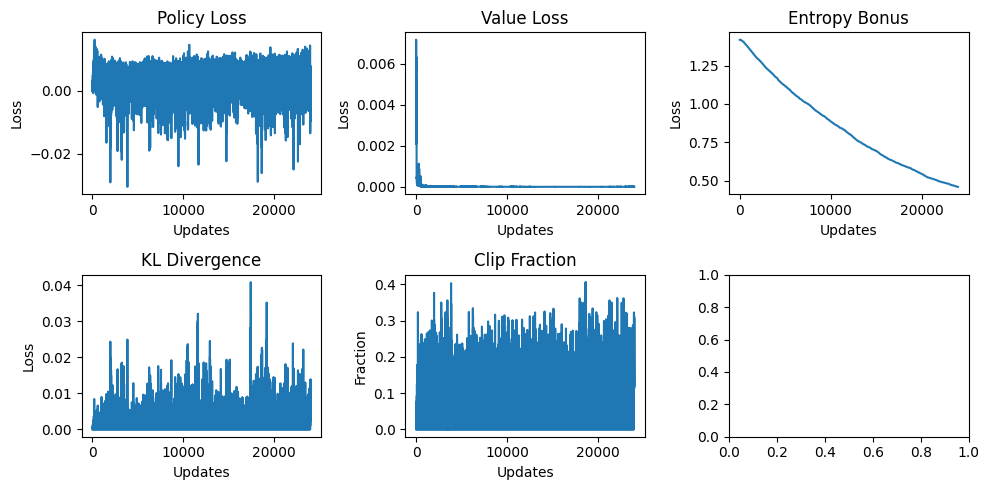

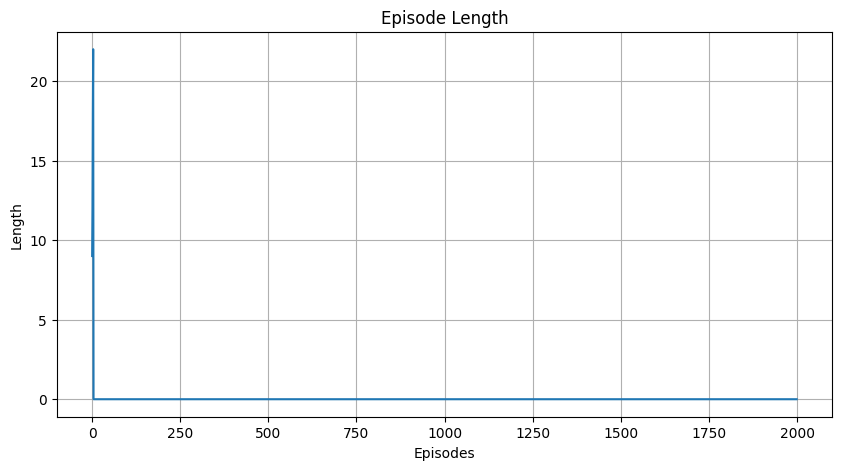

In [8]:
trainer.plot(str_env)